<a href="https://colab.research.google.com/github/NassarX/Brain-Tumor-MRI-Classifier/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Section

Please ignore that section if you're working locally!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Clone Repo

In [ ]:
# Clone repo and navigate to root directory
!git clone https://github.com/NassarX/Brain-Tumor-MRI-Classifier.git '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-MRI-Classifier'

#### Kaggle credentials

Upload your Kaggle API credentials file (usually named kaggle.json) to the Colab environment.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"nassarx","key":"22aae93f49e896250c87de8ce24169cd"}'}

In [52]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'
!mv kaggle.json /content/drive/MyDrive/Colab\ Notebooks/

#### Navigate to project path

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Brain-Tumor-MRI-Classifier

/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-MRI-Classifier


**Make sure to pull latest updates each time and after pushing any changes as Colab not saving history !**



In [59]:
!git pull origin main

From https://github.com/NassarX/Brain-Tumor-MRI-Classifier
 * branch            main       -> FETCH_HEAD
Already up to date.


In [53]:
# Current path
!pwd

/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-MRI-Classifier


# Import required libraries

In [48]:
import os
import sys
import configparser
from matplotlib import pyplot as plt
import numpy as np
import cv2
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
# append and import custom modules
%reload_ext autoreload
%autoreload 2
module_path = os.path.abspath(os.path.join('./utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.preprocess import *

# Dataset Preparation

### Load configs

Load the config file and access dataset values.

In [50]:
# Load the config file
config = configparser.ConfigParser()
config.read('config.ini')

# access values from the config file
dataset_url = config.get('data', 'dataset_url')
downloads_path = config.get('data', 'downloads_path')
dataset_path = config.get('data', 'dataset_path')
train_dataset = config.get('data', 'training_dataset')
test_dataset = config.get('data', 'testing_dataset')
orgnl_train_dataset = config.get('data', 'original_training_dataset')

### Download dataset

Download the dataset from Kaggle into the `downloads` directory and unzip it.

**Note: make sure to have your Kaggle API credentials set up beforehand**

In [54]:
setup_dataset(dataset_url, downloads_path)

[1] Downloading dataset...
	Starting download process
[2] Unzipping dataset...
	Extracting files of downloads/brain-tumor-mri-dataset.zip


Extracting: 100%|██████████| 7023/7023 [00:51<00:00, 136.87it/s]

	Done with downloads/brain-tumor-mri-dataset.zip
Dataset downloaded and unzipped successfully.


### Extract images

In order to crop the part that contains only the brain of the image, We used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

The following function __`extract_images`__ for every image in downloads folder (original images) does the following:

- Read the image.
- Crop the part of the image representing only the brain.
- Save cropped images under new location `Dataset` .

In [ ]:
extract_images(downloads_path, dataset_path)

Extracting images...


Processing brain-tumor-mri-dataset/Testing/glioma images: 100%|██████████| 300/300 [00:05<00:00, 51.42it/s]
Processing brain-tumor-mri-dataset/Testing/meningioma images: 100%|██████████| 306/306 [00:05<00:00, 51.06it/s]
Processing brain-tumor-mri-dataset/Testing/notumor images: 100%|██████████| 405/405 [00:05<00:00, 71.36it/s]
Processing brain-tumor-mri-dataset/Testing/pituitary images: 100%|██████████| 300/300 [00:06<00:00, 46.25it/s]
Processing brain-tumor-mri-dataset/Training/glioma images: 100%|██████████| 1321/1321 [00:26<00:00, 49.48it/s]
Processing brain-tumor-mri-dataset/Training/meningioma images: 100%|██████████| 1339/1339 [00:28<00:00, 47.59it/s]
Processing brain-tumor-mri-dataset/Training/notumor images: 100%|██████████| 1595/1595 [00:27<00:00, 58.62it/s]
Processing brain-tumor-mri-dataset/Training/pituitary images: 100%|██████████| 1457/1457 [00:34<00:00, 41.88it/s]

Images cropped successfully.


In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

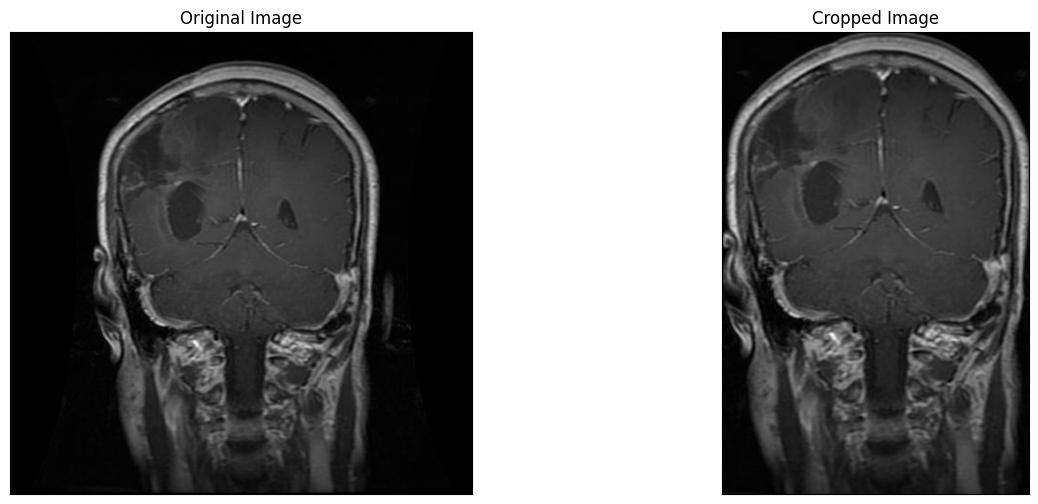

In [ ]:
ex_img = cv2.imread(os.path.join(orgnl_train_dataset, 'glioma', 'Tr-gl_0010.jpg'))
ex_new_img = extract_contour(ex_img)

# Exploratory Data Analysis

In [ ]:
labels = ['pituitary', 'notumor', 'glioma', 'meningioma']

In [ ]:
# Check the number of images in each class in the training dataset
files_path_dict = {}
num_images_per_label = []
label_names = []
num_testing_images = {}
for label in labels:
    files_path_dict[label] = [os.path.join(train_dataset, label, x) for x in os.listdir(os.path.join(train_dataset, label))]
    num_testing_images[label] = len([os.path.join(test_dataset, label, x) for x in os.listdir(os.path.join(test_dataset, label))])
    num_images_per_label.append(len(files_path_dict[label]))
    label_names.append(label)
    print('Number of images in {}: {}'.format(label, len(files_path_dict[label])))

print(num_testing_images)

Number of images in pituitary: 1457
Number of images in notumor: 1595
Number of images in glioma: 1321
Number of images in meningioma: 1339
{'pituitary': 300, 'notumor': 405, 'glioma': 300, 'meningioma': 306}


### Visualize Data Distribution

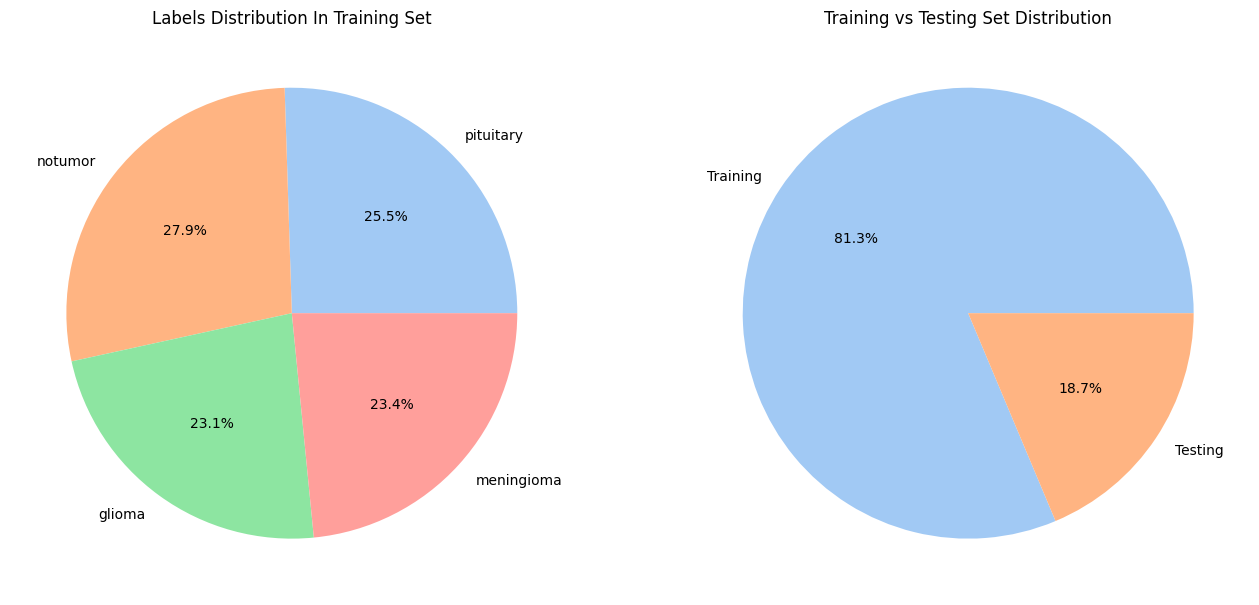

In [ ]:
# visualize class distribution in train set
plt.figure(figsize=(16, 8))
colors = sns.color_palette('pastel')

plt.subplot(1, 2, 1)
plt.pie(num_images_per_label, labels=label_names, autopct='%1.1f%%', colors=colors)
plt.title('Labels Distribution In Training Set')

plt.subplot(1, 2, 2)
plt.pie([sum(num_images_per_label), sum(num_testing_images.values())], labels=['Training', 'Testing'], autopct='%1.1f%%', colors=colors)
plt.title('Training vs Testing Set Distribution')

plt.show()

**AS WE CAN SEE THAT THE DATASET IS REASONABLY BALANCED.**

### Plot Samples

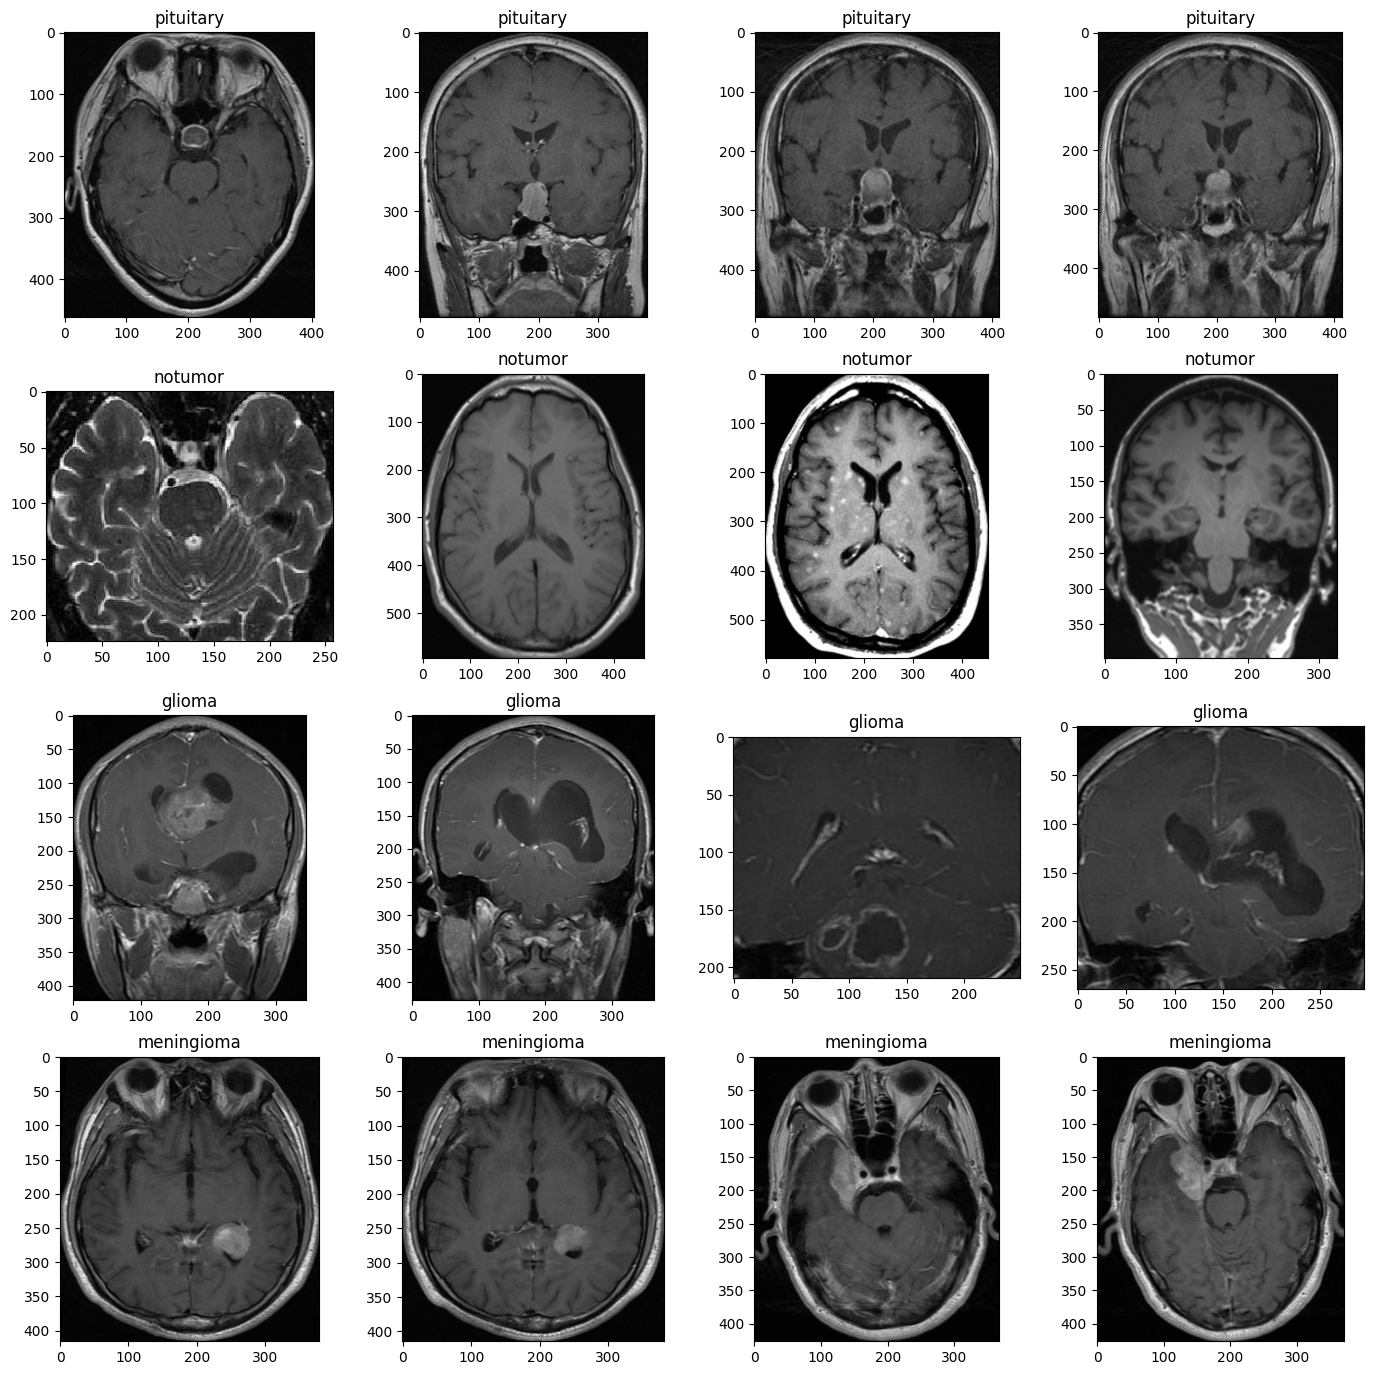

In [ ]:
plt.figure(figsize = (17,17))
index = 0
for label in labels:
  path_list = files_path_dict[label][:5]
  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(cv2.imread(path_list[i]))
    plt.title(label)

# Dataset Loading & Preprocessing

In order to load training & testing dataset and labeling each element, the following function does the following :

- Read the image in gray.
- Preprocess the image
    - Resize the image to (265, 265) to feed it as an input to the neural network.
    - Apply normalization because we want pixel values to be scaled to the range 0-1.
    - Append the image to X and its label to y.
    - Convert to numby arrays & shuffle the data.

In [ ]:
def load_data(dataset_path, labels):
    """ Load each label dataset into list.
    Parameters:
        dataset_path(str): Name of the path for the label dataset.
    Returns: 2 lists of data & labels
    """

    X = []
    y = []
    for label in labels:
        label_data = os.path.join(dataset_path, label)
        for filename in os.listdir(label_data):
            file_path = os.path.join(label_data, filename)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            image = preprocess_image(image)
            X.append(image)
            y.append(labels.index(label))

    X = np.array(X)
    y = np.array(y)

     # Shuffle the data
    X, y = shuffle(X, y)

    return X, y

### Load datasets

In [ ]:
X, y = load_data(train_dataset, labels)
X_test, y_test = load_data(test_dataset, labels)

In [ ]:
print(f'Number of examples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')
print(f'Number of classes: {len(np.unique(y))}')

Number of examples is: 5712
X shape is: (5712, 256, 256)
y shape is: (5712,)
Number of classes: 4


### Split Training Dataset

Split X and y into training, validation sets.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 3998
number of validation examples = 1714
number of test examples = 1311
X_train shape: (3998, 256, 256)
Y_train shape: (3998,)
X_val shape: (1714, 256, 256)
Y_val shape: (1714,)
X_test shape: (1311, 256, 256)
Y_test shape: (1311,)


# Data Augmentation

In order to make the most of our few training examples, we will augment them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In [ ]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# Add an additional dimension (channel) grayscale to X_train
X_train_expanded = np.expand_dims(X_train, axis=-1)

# Generate augmented data on-the-fly in batches.
train_data = data_generator.flow(X_train_expanded, y_train, batch_size=32)
train_data